
# Predicting major shifts in international relations

Given data from an academically curated [The Correlates of War](http://www.correlatesofwar.org/data-sets) project that provides data on international relations from about 1820 to about 2007, <br>

<b>Can we predict major shifts in international relations, such as wars?</b>
> <b>More specifically, can we predict if a devastating war is highly likely to occur within the next five years?</b>

<b>Client:</b> international humanitarian nonprofits and/or governments who would be more prepared for major shifts in the world, and may be more informed in their efforts to act preemptively.


## Datasets used here:
* For historical world population data, I used [Worldometers](http://www.worldometers.info/world-population/world-population-by-year/) (last accessed July 19, 2018).
* Data on international wars (i.e. wars involving any number of independent states) comes from this [page](http://www.correlatesofwar.org/data-sets/COW-war) in The Correlates of War. The version of the dataset used is `4.0`. The data spans years 1823 to 2003.
* For diplomatic relations data, I accessed this [page](http://www.correlatesofwar.org/data-sets/diplomatic-exchange) on The Correlates of War website. The version of the dataset used is `2006v1`. The webpage also contains a comprehensive codebook, aka data dictionary for diplomatic relations data. The data spans years 1817 to 2005, with periodicity of 5 years for the most part.


## Other datasets to consider:
* The Correlates of War website has data on trade relations between 1870 and 2014. It would be interesting to see how patterns in trade relations correlate with wars.
* The same website has data on how different religions were represented in every country at different times. Are there any patterns there that may indicate an upcoming inter-state war?

***

## Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
import pandas_profiling as pdprofiling

The data I use here combines The Correlates of War data on wars, and Worldometers data on historical world population. This data wrangling and combining was done in a separate Jupyter Notebook, and is not included in this one. <br>

I interpolated world population data and combined it with war data, to estimate the ratio of deaths in battle versus world population. This will inform whether to consider a war devastating or not.

In [3]:
wars = pd.read_csv("data/batcasualties_per_war_v_worldpop.csv")
wars.head()

,WarNum,BatDeath,StartYear1,WorldPop
0,1,1000,1823,86956522
1,4,130000,1828,108695652
2,7,19283,1846,186956522
3,10,7527,1848,195652174
4,13,6000,1848,195652174


><b><i>Quick codebook</i></b> <br>

> <b>`wars`:</b>

>`WarNum`: uniquely identifies each war, numeric <br>
`BatDeath`: number of deaths in battle in a given war, numeric <br>
`StartYear1`: the year when the war started <br>
`WorldPop`: world population at the start of the war

### Let's see the distribution of values for: 
### `(war casualties for each war)/ (world population at the time)`

In [4]:
wars['casualtiesVWorldPop'] = wars['BatDeath']*1.0/wars['WorldPop']

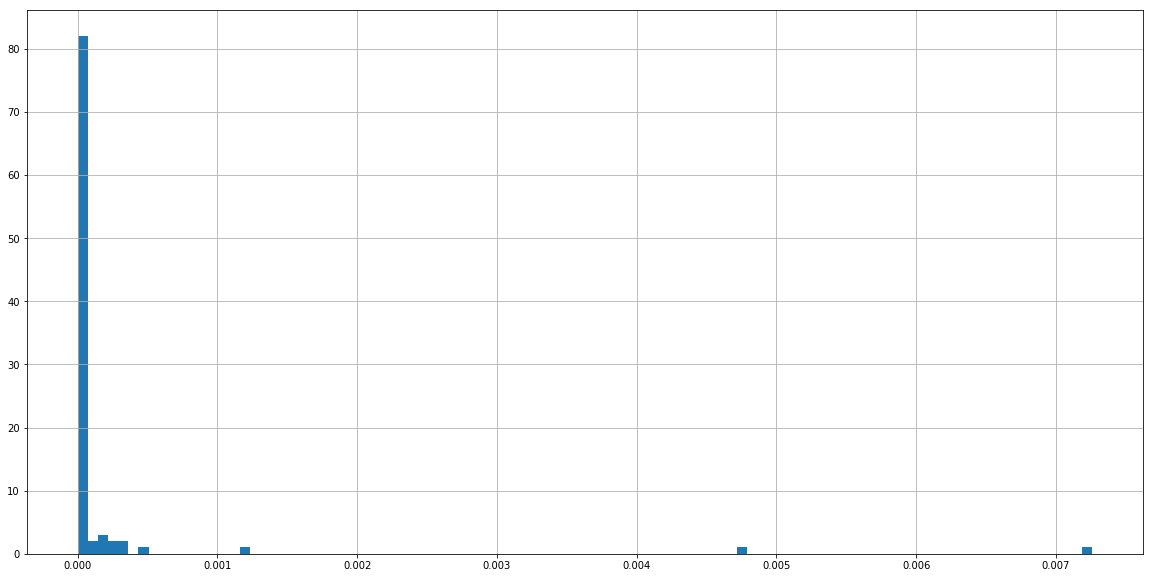

In [5]:
from matplotlib.pyplot import figure
fig = figure(figsize = (20, 10))
wars['casualtiesVWorldPop'].hist(bins = 100)
plt.show()

Zoom in on the area with most values:

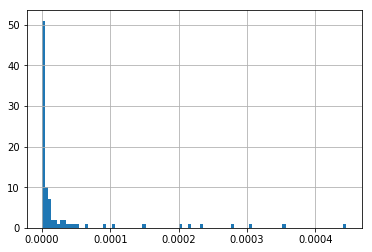

In [47]:
wars[wars['casualtiesVWorldPop']<0.001]['casualtiesVWorldPop'].hist(bins = 100)
plt.show()

Unfortunately, we do not have total deaths numbers for each war, that would include civilian casualties, so we will have to assume that these numbers are highly positively correlated with deaths in battle. <br>

<b> As we see from above, wars where 1 in every 10,000 living persons die, are quite rare. So let's take that as a definition of a devastating war: one, where more than 1 in every 10,000 living persons die in battle.</b>

In [6]:
(wars['casualtiesVWorldPop']>0.0001).sum()

12

There are 12 such wars that happened between 1823 and 2007.

In [7]:
wars['is_highDeath'] = (wars['casualtiesVWorldPop']>0.0001).astype(int)
wars.head()

,WarNum,BatDeath,StartYear1,WorldPop,casualtiesVWorldPop,is_highDeath
0,1,1000,1823,86956522,0.000011,0
1,4,130000,1828,108695652,0.001196,1
2,7,19283,1846,186956522,0.000103,1
3,10,7527,1848,195652174,0.000038,0
4,13,6000,1848,195652174,0.000031,0


In [8]:
wars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
WarNum                 95 non-null int64
BatDeath               95 non-null int64
StartYear1             95 non-null int64
WorldPop               95 non-null int64
casualtiesVWorldPop    95 non-null float64
is_highDeath           95 non-null int32
dtypes: float64(1), int32(1), int64(4)
memory usage: 4.2 KB


### Now let's read in the full dataset on wars as obtained from The Correlates of War website.

In [9]:
wars_w_countries_etc = pd.read_csv('data/Inter-StateWarData_v4.0.csv')

In [10]:
wars_w_countries_etc.head()

,WarNum,WarName,WarType,ccode,StateName,Side,StartMonth1,StartDay1,StartYear1,EndMonth1,...,EndMonth2,EndDay2,EndYear2,TransFrom,WhereFought,Initiator,Outcome,TransTo,BatDeath,Version
0,1,Franco-Spanish War,1,230,Spain,2,4,7,1823,11,...,-8,-8,-8,503,2,2,2,-8,600,4
1,1,Franco-Spanish War,1,220,France,1,4,7,1823,11,...,-8,-8,-8,503,2,1,1,-8,400,4
2,4,First Russo-Turkish,1,640,Ottoman Empire,2,4,26,1828,9,...,-8,-8,-8,506,11,2,2,-8,80000,4
3,4,First Russo-Turkish,1,365,Russia,1,4,26,1828,9,...,-8,-8,-8,506,11,1,1,-8,50000,4
4,7,Mexican-American,1,70,Mexico,2,4,25,1846,9,...,-8,-8,-8,-8,1,2,2,-8,6000,4


> <b><i>Quick codebook</i></b> <br>

> <b>`wars_w_countries_etc`:</b>

> There are quite a few columns in there, but the only one that we have not seen before, that is relevant to our analysis is: <br>
`ccode`: uniquely identifies each country, numeric <br>

### Next step: identifiying especially war prone countries up to a given year.

First sort the wars by start year.

In [11]:
wars_w_countries_etc.sort_values(by='StartYear1', inplace=True)

Are there duplicates in the ('WarNum', 'ccode') tuples in the data?

In [12]:
len(wars_w_countries_etc[['WarNum', 'ccode']].drop_duplicates()) == len(wars_w_countries_etc)

False

Indeed, there are. This is because there are cases where the same country entered and exited the same war at different times, with each new entry into the war corresponding to a separate record. <br>
Let's remove those duplicates, while separating away only the data we need, and placing it in `war_country_year`.

In [13]:
war_country_year = wars_w_countries_etc[['WarNum', 'ccode', 'StartYear1']].drop_duplicates(['WarNum', 'ccode'])

In [15]:
from collections import defaultdict

Through trial and error, as well as through knowledge of how likely different countries were to into war at different points in history, I chose to consider a set of countries the most war-prone at a particular year if: <br>
* they are the top 10% of the countries who participated in the most wars up to that year <br>
* <i>or</i> the top 7 countries, whichever set is smaller.<br>

See below how I go about calculating this data.

In [16]:
year_country_dict = defaultdict(list)
for year in range(1823, 2006):
    # create a dataframe with all wars up to the year
    wars_so_far = war_country_year[war_country_year['StartYear1'] <= year]
    
    # create a dataframe with all countries and number of wars they have been in up to that year, sort in descending order
    country_numWars = wars_so_far[['WarNum', 'ccode']].groupby('ccode', sort = False).count().sort_values(by = 'WarNum', ascending = False).reset_index()
    
    # list of countries that were the most war-prone up to that year: top10percent
    top10percent = country_numWars.head(min(len(country_numWars)//10 + 1, 7))['ccode'].tolist()
    
    # add to the dictionary in the format key: year, value: list of codes of war-prone countries
    year_country_dict[year] = top10percent

In [17]:
year_country_dict[1947]

[365, 220, 325, 640, 740, 710, 255]

The  values in the dictionary are country codes, so do not say anything immediately to you. <br>

Here's the interpretation: the top 7 war-prone countries in 1947 were Soviet Union, France, Italy, Germany, Turkey, China, and Japan.

We will use the dictionary that we just obtained,`year_country_dict`, in our next section where we will wrangle diplomatic relations data.

***
## Diplomatic relations numbers for each year:

We will look at the following metrics for each year we have diplomatic relations data for:

1. Diplomatic connectedness of the world 
1. Diplomatic connectedness of the most war-prone countries to the world, using `year_country_dict`

In [18]:
diplomatics = pd.read_csv('data/Diplomatic_Exchange_2006v1.csv')
diplomatics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310820 entries, 0 to 310819
Data columns (total 7 columns):
ccode1     310820 non-null int64
ccode2     310820 non-null int64
year       310820 non-null int64
DR_at_1    310820 non-null int64
DR_at_2    310820 non-null int64
DE         310820 non-null int64
version    310820 non-null float64
dtypes: float64(1), int64(6)
memory usage: 16.6 MB


> <b><i>Quick codebook</i></b> <br>

> Columns of interest in <b>`diplomatics`:</b>

> `ccode1`: identifies the first country in a diplomatic relationship using the country code, numeric <br>
`ccode2`: identifies the second country in a diplomatic relationship using the country code, numeric <br>
`year`: the year at which the 'snapshot' of the relationship was taken <br>
`DE`: If this field has value 1, the relationship exists in some form, i.e. at least one of the two countries has a diplomatic presence in the other one. If the value is 0, no relationship exists.



Note: a diplomatic relationship between two countries (i.e. having some sort of diplomatic presence in either direction) is a symmetric relation.

In [19]:
warnings.filterwarnings("ignore", category=UserWarning)
import pandas_profiling as pdprofiling

In [20]:
pdprofiling.ProfileReport(diplomatics)

Number of variables,7
Number of observations,310820
Total Missing (%),0.0%
Total size in memory,16.6 MiB
Average record size in memory,56.0 B
Numeric,5
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


<b>First computed column:</b> number of countries for each year that are mentioned in the diplomatic exchange dataset. This is basically how many countries had any diplomatic connections that year. 

In [21]:
de_numCountries = diplomatics[['year', 'ccode1']].drop_duplicates().groupby('year').count()
de_numCountries.columns = ['numCountries']
de_numCountries.head()

,numCountries
year,
1817,23
1824,23
1827,25
1832,29
1836,29


<b>Second computed column:</b> number of diplomatic connections that existed between countries each year

In [22]:
de_numDirectedConns = diplomatics[diplomatics['DE'] == 1][['year', 'ccode1']].groupby('year').count()
de_numDirectedConns.columns = ['numConns']
de_numDirectedConns.head()

,numConns
year,
1817,260
1824,242
1827,296
1832,314
1836,316


In [23]:
de_noInterpolation = pd.concat([de_numCountries, de_numDirectedConns], axis = 1)
de_noInterpolation.head()

,numCountries,numConns
year,,
1817,23,260
1824,23,242
1827,25,296
1832,29,314
1836,29,316


<b>Third computed column:</b> diplomatic connectedness of the world. For each year: divide total number of connections by total possible number of connections.

In [24]:
de_noInterpolation['connectivity_ratio'] = de_noInterpolation['numConns']*1.0/(de_noInterpolation['numCountries']*(de_noInterpolation['numCountries']-1))

<b>No let's do similar analysis for our war-prone countries.</b>

In [25]:
# from diplomatic relations data, extract only the columns we need to calculate war-prone countries' connectedness 
diplomatics_slice = diplomatics[['year', 'ccode1', 'DE']]

In [26]:
warprone_c_connections = defaultdict(list)

# for each year with diplomatic exchange data
for year in de_noInterpolation.index:
    # compute number of diplomatic connections that war-prone countries had that year in total: all_warlike_countries_conns
    all_warlike_countries_conns = diplomatics_slice[(diplomatics_slice['ccode1'].isin(year_country_dict[year])) & (diplomatics_slice['year'] == year)]['DE'].sum()
    
    # for the same year add (year, [all war-prone countries' connections, number of war-prone countries]) to warprone_c_connections dictionary: 
    warprone_c_connections[year].extend([all_warlike_countries_conns, len(year_country_dict[year])])
warprone_c_connections

defaultdict(list,
            {1817: [0, 0],
             1824: [10, 1],
             1827: [16, 1],
             1832: [16, 1],
             1836: [15, 1],
             1840: [11, 1],
             1844: [14, 1],
             1849: [59, 2],
             1854: [48, 2],
             1859: [60, 2],
             1864: [78, 3],
             1869: [99, 4],
             1874: [100, 4],
             1879: [110, 4],
             1884: [119, 4],
             1889: [128, 4],
             1894: [132, 4],
             1899: [134, 4],
             1904: [140, 4],
             1909: [184, 5],
             1914: [158, 5],
             1920: [150, 6],
             1925: [211, 6],
             1930: [210, 6],
             1935: [254, 6],
             1940: [287, 7],
             1950: [229, 7],
             1955: [368, 7],
             1960: [437, 7],
             1965: [573, 7],
             1970: [681, 7],
             1975: [808, 7],
             1980: [928, 7],
             1985: [811, 7],
         

Adding the information on war-prone countries to the `de_noInterpolation` dataframe.

In [27]:
de_noInterpolation = de_noInterpolation.join(pd.DataFrame.from_dict(warprone_c_connections, orient = 'index'))
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,0,1
year,,,,,
1817,23,260,0.513834,0,0
1824,23,242,0.478261,10,1
1827,25,296,0.493333,16,1
1832,29,314,0.386700,16,1
1836,29,316,0.389163,15,1


In [28]:
de_noInterpolation.rename(columns = {0:'warlike_c_conns', 1:'warlike_numCountries'}, inplace = True)
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries
year,,,,,
1817,23,260,0.513834,0,0
1824,23,242,0.478261,10,1
1827,25,296,0.493333,16,1
1832,29,314,0.386700,16,1
1836,29,316,0.389163,15,1


Computing war-prone countries' degree centrality for each row: divide the number of total connections they had by the maximum number of connections they could have had.

In [29]:
de_noInterpolation['warlike_centrality'] = de_noInterpolation['warlike_c_conns']/(de_noInterpolation['warlike_numCountries']*(de_noInterpolation['numCountries']-1))
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries,warlike_centrality
year,,,,,,
1817,23,260,0.513834,0,0,NaN
1824,23,242,0.478261,10,1,0.454545
1827,25,296,0.493333,16,1,0.666667
1832,29,314,0.386700,16,1,0.571429
1836,29,316,0.389163,15,1,0.535714


In [30]:
de_noInterpolation = de_noInterpolation.fillna(0)
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries,warlike_centrality
year,,,,,,
1817,23,260,0.513834,0,0,0.000000
1824,23,242,0.478261,10,1,0.454545
1827,25,296,0.493333,16,1,0.666667
1832,29,314,0.386700,16,1,0.571429
1836,29,316,0.389163,15,1,0.535714


Let's plot the years when devastating wars began, as well as diplomatic cconnectedness data on the same axes.

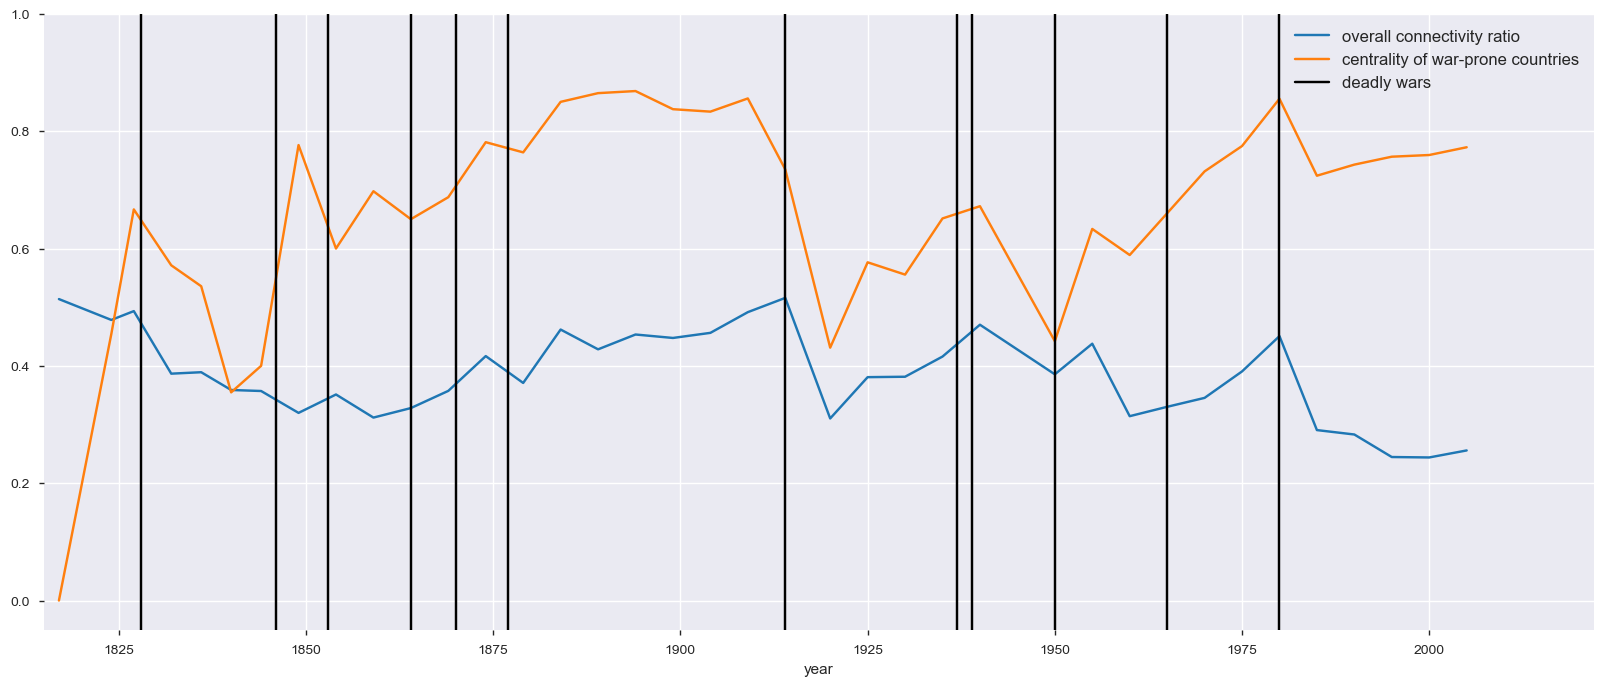

In [31]:
fig = figure(figsize=(20, 8))
de_noInterpolation['connectivity_ratio'].plot()
de_noInterpolation['warlike_centrality'].plot()
for xcoord in wars[wars['is_highDeath']==1]['StartYear1']:
    plt.axvline(x=xcoord, color = 'k')
axes = plt.gca()
axes.set_ylim([-0.05,1]) 
axes.set_xlim([1815,2022])  
plt.legend(['overall connectivity ratio', 'centrality of war-prone countries', 'deadly wars'], fontsize = 12, loc = 'best')    
plt.show()    

Eyeballing the data does not immediately lead to any insights. Let's try to do some EDA that is more formal. 

***
## Putting all data that we wrangled so far into one dataframe.

Our diplomatic relations dataframe does not contain data for each year between 1817 and 2005. But we need to merge it together with our dataset indicating the years when devastating wars started, so that we could have a cohesive story. 
> First, let's make sure each year has a row in the deadly wars dataset, and indicate which years have a deadly war coming up within the next five years.

Let's see if there were any years when more than one devastating war started.

In [32]:
deadly_wars = wars[wars['is_highDeath']==1]
deadly_wars['StartYear1'].duplicated().sum()

0

No such years: this means we are safe to make the start year into the index of the dataset.

In [33]:
deadly_wars.set_index('StartYear1', inplace = True)

In [34]:
deadly_wars = deadly_wars.reindex(list(range(1824, 2006)))
deadly_wars.head()

,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_highDeath
StartYear1,,,,,
1824,NaN,NaN,NaN,NaN,NaN
1825,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN
1827,NaN,NaN,NaN,NaN,NaN
1828,4.0,130000.0,108695652.0,0.001196,1.0


Let's have our last column indicate if a devastating war is going to happen within 5 years: `is_HighDeathInNxt5Yrs`.

In [35]:
wars_interpolated = deadly_wars.copy()
wars_interpolated.rename(columns = {'is_highDeath':'is_HighDeathInNxt5Yrs'}, inplace = True)
wars_interpolated.head()

,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_HighDeathInNxt5Yrs
StartYear1,,,,,
1824,NaN,NaN,NaN,NaN,NaN
1825,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN
1827,NaN,NaN,NaN,NaN,NaN
1828,4.0,130000.0,108695652.0,0.001196,1.0


In [36]:
for i in wars_interpolated[wars_interpolated['is_HighDeathInNxt5Yrs']==1].index:
    if (i-1) in(wars_interpolated.index): wars_interpolated.loc[i-1, 'is_HighDeathInNxt5Yrs'] = 1
    if (i-2) in(wars_interpolated.index): wars_interpolated.loc[i-2, 'is_HighDeathInNxt5Yrs'] = 1
    if (i-3) in(wars_interpolated.index): wars_interpolated.loc[i-3, 'is_HighDeathInNxt5Yrs'] = 1
    if (i-4) in(wars_interpolated.index): wars_interpolated.loc[i-4, 'is_HighDeathInNxt5Yrs'] = 1
wars_interpolated.head(15)    

,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_HighDeathInNxt5Yrs
StartYear1,,,,,
1824,NaN,NaN,NaN,NaN,1.0
1825,NaN,NaN,NaN,NaN,1.0
1826,NaN,NaN,NaN,NaN,1.0
1827,NaN,NaN,NaN,NaN,1.0
1828,4.0,130000.0,108695652.0,0.001196,1.0
1829,NaN,NaN,NaN,NaN,NaN
1830,NaN,NaN,NaN,NaN,NaN
1831,NaN,NaN,NaN,NaN,NaN
1832,NaN,NaN,NaN,NaN,NaN


All other years' `is_HighDeathInNxt5Yrs` values will be set to zero.

In [38]:
wars_interpolated.fillna({'is_HighDeathInNxt5Yrs':0}, inplace=True)

We can finally merge our wars dataset and our diplomatic exchange dataset!

In [39]:
de_df = de_noInterpolation.join(wars_interpolated, how ='left')
de_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1817 to 2005
Data columns (total 11 columns):
numCountries             38 non-null int64
numConns                 38 non-null int64
connectivity_ratio       38 non-null float64
warlike_c_conns          38 non-null int64
warlike_numCountries     38 non-null int64
warlike_centrality       38 non-null float64
WarNum                   5 non-null float64
BatDeath                 5 non-null float64
WorldPop                 5 non-null float64
casualtiesVWorldPop      5 non-null float64
is_HighDeathInNxt5Yrs    37 non-null float64
dtypes: float64(7), int64(4)
memory usage: 4.8 KB


In [40]:
de_df[de_df['is_HighDeathInNxt5Yrs'].isna()]

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries,warlike_centrality,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_HighDeathInNxt5Yrs
year,,,,,,,,,,,
1817,23,260,0.513834,0,0,0.0,NaN,NaN,NaN,NaN,NaN


In [41]:
de_df.loc[1817, 'is_HighDeathInNxt5Yrs'] = 0

In [42]:
de_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1817 to 2005
Data columns (total 11 columns):
numCountries             38 non-null int64
numConns                 38 non-null int64
connectivity_ratio       38 non-null float64
warlike_c_conns          38 non-null int64
warlike_numCountries     38 non-null int64
warlike_centrality       38 non-null float64
WarNum                   5 non-null float64
BatDeath                 5 non-null float64
WorldPop                 5 non-null float64
casualtiesVWorldPop      5 non-null float64
is_HighDeathInNxt5Yrs    38 non-null float64
dtypes: float64(7), int64(4)
memory usage: 4.8 KB


#### The data that we have so far has too few observations, for any kind of meaningful  predictive modelling. We will need to fill in the missing predictor data, so that each row corresponds to each year from ~1817 - 2005.

Let's simply interpolate connectivity ratio and warlike centrality. The assumption here is that in the years for which we don't have diplomatic exchange data, diplomatic exchange built up / broke down gradually.

In [49]:
df_smpl_interp = de_df[['connectivity_ratio', 'warlike_centrality']].reindex(list(range(1824, 2006)))
df_smpl_interp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 1824 to 2005
Data columns (total 2 columns):
connectivity_ratio    37 non-null float64
warlike_centrality    37 non-null float64
dtypes: float64(2)
memory usage: 4.3 KB


In [50]:
df_smpl_interp.interpolate(inplace = True)
df_smpl_interp_formodel = df_smpl_interp.join(wars_interpolated[['is_HighDeathInNxt5Yrs']])
df_smpl_interp_formodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 1824 to 2005
Data columns (total 3 columns):
connectivity_ratio       182 non-null float64
warlike_centrality       182 non-null float64
is_HighDeathInNxt5Yrs    182 non-null float64
dtypes: float64(3)
memory usage: 10.7 KB


In [51]:
df_smpl_interp_formodel.head()

,connectivity_ratio,warlike_centrality,is_HighDeathInNxt5Yrs
year,,,
1824,0.478261,0.454545,1.0
1825,0.483285,0.525253,1.0
1826,0.488309,0.595960,1.0
1827,0.493333,0.666667,1.0
1828,0.472007,0.647619,1.0


Let's visualize our data in three dimensions. Red dots represent the years, after which within five years, a major war broke out.

In [67]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [75]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 7

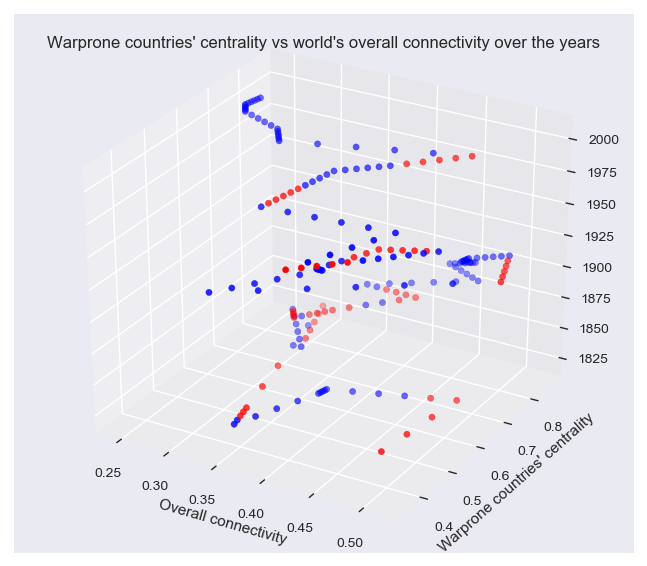

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_smpl_interp_formodel.connectivity_ratio, df_smpl_interp_formodel.warlike_centrality, df_smpl_interp_formodel.index, \
            c=[cm_bright.colors[i] for i in  df_smpl_interp_formodel.is_HighDeathInNxt5Yrs==0])
plt.xlabel('Overall connectivity')
plt.ylabel("Warprone countries' centrality")
plt.title("Warprone countries' centrality vs world's overall connectivity over the years")
plt.show()

***
# Time series analysis

### 1. Let's run tests to see if our variables are trend-stationary

In [59]:
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.stattools import grangercausalitytests, kpss, adfuller

In [60]:
print(adfuller(df_smpl_interp_formodel['is_HighDeathInNxt5Yrs']))
print(adfuller(df_smpl_interp_formodel['warlike_centrality']))
print(adfuller(df_smpl_interp_formodel['connectivity_ratio']))

(-2.8018381997079396, 0.058011673691050245, 10, 171, {'1%': -3.4691814633722453, '5%': -2.878595143532943, '10%': -2.5758625549741803}, 64.18076954021899)
(-2.4435590731975223, 0.12981758077408628, 6, 175, {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}, -971.5149693571336)
(-2.1411683611166867, 0.22828589879021943, 7, 174, {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}, -1167.4064004021263)


In [61]:
print(kpss(df_smpl_interp_formodel['is_HighDeathInNxt5Yrs']))
print(kpss(df_smpl_interp_formodel['warlike_centrality']))
print(kpss(df_smpl_interp_formodel['connectivity_ratio']))

(0.27073280025083063, 0.1, 14, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.17146294625565062, 0.1, 14, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.341221074847182, 0.1, 14, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


Conclusion 1: connectivity ratio, warlike cenrality, and likelihood of war are all trend-stationary.

### 2. Let's run Granger causality tests on each of our predictor vs target variable.

In [54]:
print(grangercausalitytests(df_smpl_interp_formodel[['is_HighDeathInNxt5Yrs','warlike_centrality']],4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8218  , p=0.3659  , df_denom=178, df_num=1
ssr based chi2 test:   chi2=0.8356  , p=0.3606  , df=1
likelihood ratio test: chi2=0.8337  , p=0.3612  , df=1
parameter F test:         F=0.8218  , p=0.3659  , df_denom=178, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0628  , p=0.1302  , df_denom=175, df_num=2
ssr based chi2 test:   chi2=4.2434  , p=0.1198  , df=2
likelihood ratio test: chi2=4.1942  , p=0.1228  , df=2
parameter F test:         F=2.0628  , p=0.1302  , df_denom=175, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4977  , p=0.2170  , df_denom=172, df_num=3
ssr based chi2 test:   chi2=4.6758  , p=0.1971  , df=3
likelihood ratio test: chi2=4.6158  , p=0.2022  , df=3
parameter F test:         F=1.4977  , p=0.2170  , df_denom=172, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7496  , p=0.1414  

In [55]:
print(grangercausalitytests(df_smpl_interp_formodel[['warlike_centrality', 'is_HighDeathInNxt5Yrs']],4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5198  , p=0.4719  , df_denom=178, df_num=1
ssr based chi2 test:   chi2=0.5286  , p=0.4672  , df=1
likelihood ratio test: chi2=0.5278  , p=0.4675  , df=1
parameter F test:         F=0.5198  , p=0.4719  , df_denom=178, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5209  , p=0.2214  , df_denom=175, df_num=2
ssr based chi2 test:   chi2=3.1286  , p=0.2092  , df=2
likelihood ratio test: chi2=3.1018  , p=0.2121  , df=2
parameter F test:         F=1.5209  , p=0.2214  , df_denom=175, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0070  , p=0.3911  , df_denom=172, df_num=3
ssr based chi2 test:   chi2=3.1439  , p=0.3700  , df=3
likelihood ratio test: chi2=3.1166  , p=0.3740  , df=3
parameter F test:         F=1.0070  , p=0.3911  , df_denom=172, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9988  , p=0.0969  

Conclusion 2.1: Assuming alpha = 0.05, neither warlike centrality Granger causes likelihood of war, nor the other way around.

In [56]:
print(grangercausalitytests(df_smpl_interp_formodel[['is_HighDeathInNxt5Yrs','connectivity_ratio']],4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0557  , p=0.8136  , df_denom=178, df_num=1
ssr based chi2 test:   chi2=0.0567  , p=0.8118  , df=1
likelihood ratio test: chi2=0.0567  , p=0.8118  , df=1
parameter F test:         F=0.0557  , p=0.8136  , df_denom=178, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4730  , p=0.6239  , df_denom=175, df_num=2
ssr based chi2 test:   chi2=0.9731  , p=0.6147  , df=2
likelihood ratio test: chi2=0.9705  , p=0.6155  , df=2
parameter F test:         F=0.4730  , p=0.6239  , df_denom=175, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2725  , p=0.8452  , df_denom=172, df_num=3
ssr based chi2 test:   chi2=0.8508  , p=0.8373  , df=3
likelihood ratio test: chi2=0.8488  , p=0.8378  , df=3
parameter F test:         F=0.2725  , p=0.8452  , df_denom=172, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1459  , p=0.9646  

In [57]:
print(grangercausalitytests(df_smpl_interp_formodel[['connectivity_ratio', 'is_HighDeathInNxt5Yrs']],4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3995  , p=0.0374  , df_denom=178, df_num=1
ssr based chi2 test:   chi2=4.4737  , p=0.0344  , df=1
likelihood ratio test: chi2=4.4193  , p=0.0355  , df=1
parameter F test:         F=4.3995  , p=0.0374  , df_denom=178, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0028  , p=0.1380  , df_denom=175, df_num=2
ssr based chi2 test:   chi2=4.1201  , p=0.1275  , df=2
likelihood ratio test: chi2=4.0736  , p=0.1304  , df=2
parameter F test:         F=2.0028  , p=0.1380  , df_denom=175, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1188  , p=0.3430  , df_denom=172, df_num=3
ssr based chi2 test:   chi2=3.4930  , p=0.3217  , df=3
likelihood ratio test: chi2=3.4594  , p=0.3261  , df=3
parameter F test:         F=1.1188  , p=0.3430  , df_denom=172, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9317  , p=0.4470  

Conclusion 2.2: War likelihood seems to cause overall connectivity ratio to change in the next year.

Based on conclusions 2.1 and 2.2, it's unlikely that ARIMAX will work for our dataset.

### 3. Let's try running an ARIMAX for our dataset, nevertheless

In [62]:
import statsmodels.api as sm

In [63]:
de_df_trimmed = de_df.copy()[['connectivity_ratio', 'warlike_centrality','is_HighDeathInNxt5Yrs' ]]
de_df_trimmed['const'] = 1

model1=sm.OLS(endog=de_df_trimmed['is_HighDeathInNxt5Yrs'], exog=de_df_trimmed[['warlike_centrality', 'connectivity_ratio', 'const']])
results1=model1.fit()
print(results1.summary())

                              OLS Regression Results                             
Dep. Variable:     is_HighDeathInNxt5Yrs   R-squared:                       0.033
Model:                               OLS   Adj. R-squared:                 -0.022
Method:                    Least Squares   F-statistic:                    0.6035
Date:                   Sat, 11 Aug 2018   Prob (F-statistic):              0.552
Time:                           21:44:09   Log-Likelihood:                -24.164
No. Observations:                     38   AIC:                             54.33
Df Residuals:                         35   BIC:                             59.24
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
warlik

Add lags based on our predictor variables.

In [64]:
de_df_trimmed['wc_lag']=de_df_trimmed['warlike_centrality'].shift()
de_df_trimmed['cr_lag']=de_df_trimmed['connectivity_ratio'].shift()

In [65]:
model2=sm.OLS(endog=de_df_trimmed['is_HighDeathInNxt5Yrs'], exog=de_df_trimmed[['warlike_centrality', 'connectivity_ratio', 'wc_lag', 'cr_lag',  'const']])
results1=model1.fit()
print(results1.summary())

                              OLS Regression Results                             
Dep. Variable:     is_HighDeathInNxt5Yrs   R-squared:                       0.033
Model:                               OLS   Adj. R-squared:                 -0.022
Method:                    Least Squares   F-statistic:                    0.6035
Date:                   Sat, 11 Aug 2018   Prob (F-statistic):              0.552
Time:                           21:48:19   Log-Likelihood:                -24.164
No. Observations:                     38   AIC:                             54.33
Df Residuals:                         35   BIC:                             59.24
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
warlik

ARIMAX does not return promising results, so we will have to dismiss time series analysis as a viable method here.
***

## Feature engineering before we get into classification

Since time series analysis was not promising, it's worth encoding the year feature in a more generalized way. One possibility is to use years since last war instead.

In [82]:
war_years = list(deadly_wars.dropna().index)

For our very first several years before the first war in our dataset, we will need a year of the last major war that happened before 1824. Research showed that there was a major war in 1815 that eliminated over 1/10,000 of the total world population.

In [83]:
war_years.insert(0, 1815)

In [84]:
war_years = np.array(war_years)
years_aft_lst_w_dict = {}
# for each year, compute how long it's been since last major war

for year in range(1824, 2006):
    years_aft_lst_w_dict[year] = min(i for i in year-war_years if i >= 0)

df_smpl_interp_formodel['years_aft_lst_w'] = df_smpl_interp_formodel.index.map(years_aft_lst_w_dict)
df_smpl_interp_formodel.head()

,connectivity_ratio,warlike_centrality,is_HighDeathInNxt5Yrs,years_aft_lst_w
year,,,,
1824,0.478261,0.454545,1.0,9
1825,0.483285,0.525253,1.0,10
1826,0.488309,0.595960,1.0,11
1827,0.493333,0.666667,1.0,12
1828,0.472007,0.647619,1.0,0


***
## Classification
<i> Unfortunately, due a small number of samples we cannot use ensemble methods for classification. </i>

### I. Let's try drawing our train and test sets chronologically, to begin with.

<b>First idea: Support Vector Classification</b>

In [88]:
X, y = df_smpl_interp_formodel.drop(['is_HighDeathInNxt5Yrs'], axis = 1), df_smpl_interp_formodel['is_HighDeathInNxt5Yrs'] 

In [89]:
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

In [90]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score

In [91]:
from sklearn.preprocessing import StandardScaler

In [92]:
sc = StandardScaler()
train_sc_X = sc.fit_transform(train_X)
test_sc_X = sc.transform(test_X)

Define a function that runs SVC with parameters we choose, and prints out the metrics we care about.

In [93]:
def run_SVC(train_X = train_X, train_y = train_y, test_X = test_X, test_y = test_y, kernel = 'rbf', C = 1.0, gamma = 'auto', coef0 = 0.0):
    clf = svm.SVC(kernel = kernel, class_weight='balanced', random_state=10, C = C, gamma = gamma)
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    roc = roc_auc_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)

    print("Area under ROC curve: %.4f" % (roc))
    print("Recall: %.4f" % (recall))
    return pred_y

Try out different kernel types.

In [94]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y)

Area under ROC curve: 0.1000
Recall: 0.2000


array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [103]:
print("Proportion of years with wars unlikely: %.4f" % (test_y.value_counts()[0]/len(test_y)))

Proportion of years with wars unlikely: 0.8649


In [104]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y, 'linear')

Area under ROC curve: 0.0625
Recall: 0.0000


array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [105]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y, 'sigmoid')

Area under ROC curve: 0.1562
Recall: 0.0000


array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0.])

In [106]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y, 'poly')

Area under ROC curve: 0.3094
Recall: 0.4000


array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0.])

SVC has not shown any promise.

<b>Second idea: K-Nearest Neighbors</b>

In [154]:
from sklearn.preprocessing import Normalizer

In [155]:
nr = Normalizer()
train_nr_X = nr.fit_transform(train_X)
test_nr_X = nr.transform(test_X)

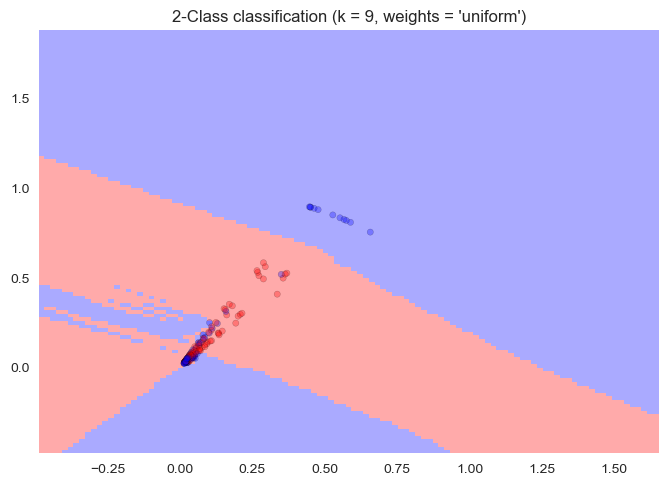

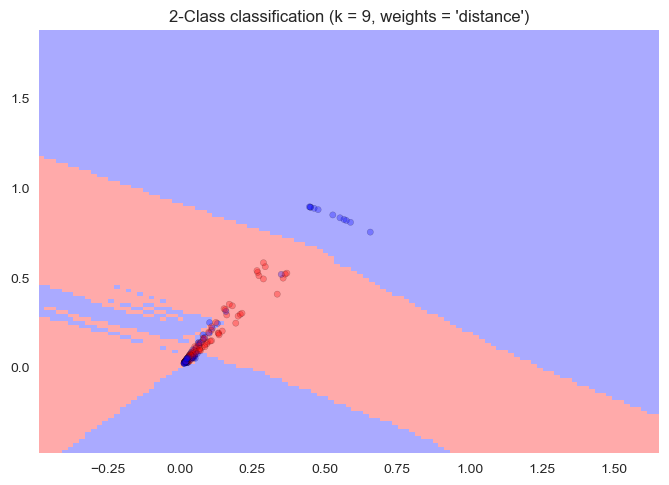

In [166]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import numpy as np

n_neighbors = 9

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(train_nr_X[:, :2], train_y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = train_nr_X[:, 0].min() - 0.5, train_nr_X[:, 0].max() + 1
    y_min, y_max = train_nr_X[:, 1].min() - 0.5, train_nr_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(train_nr_X[:, 0], train_nr_X[:, 1], c=train_y, cmap=cmap_bold,
                edgecolor='k', s=20, alpha = 0.3)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

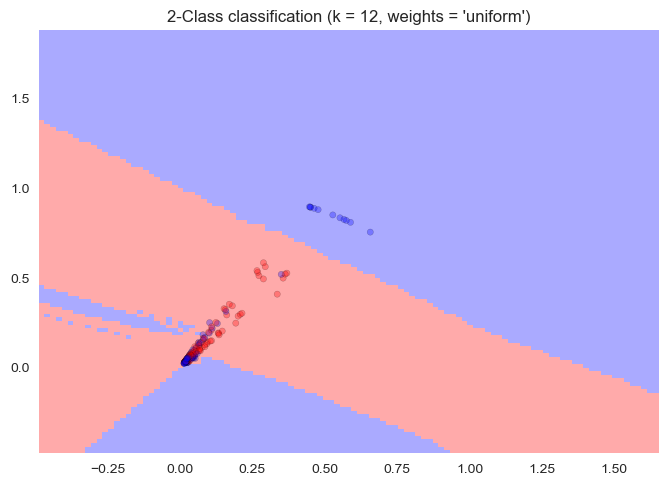

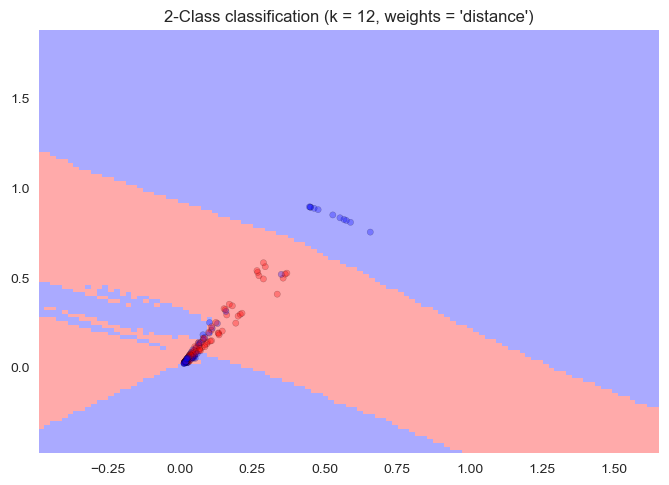

In [167]:
n_neighbors = 12

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(train_nr_X[:, :2], train_y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = train_nr_X[:, 0].min() - 0.5, train_nr_X[:, 0].max() + 1
    y_min, y_max = train_nr_X[:, 1].min() - 0.5, train_nr_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(train_nr_X[:, 0], train_nr_X[:, 1], c=train_y, cmap=cmap_bold,
                edgecolor='k', s=20, alpha = 0.3)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

Since we have three dimensional data, let's see what it looks like when it's normalized, in 3D.

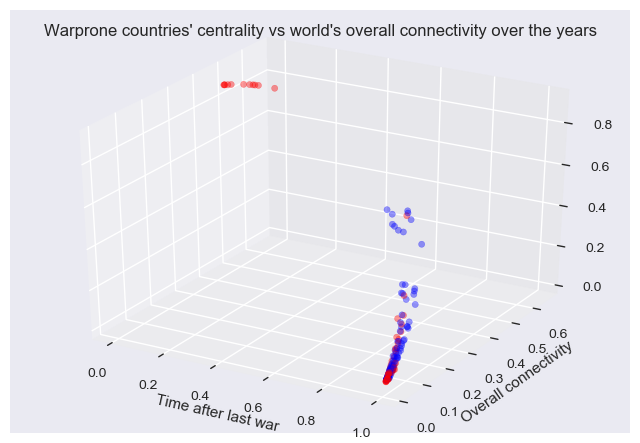

In [192]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_nr_X_df.years_aft_lst_w, train_nr_X_df.connectivity_ratio, train_nr_X_df.warlike_centrality,\
            c=[cm_bright.colors[i] for i in train_y==0], alpha = 0.4)
plt.xlabel('Time after last war')
plt.ylabel('Overall connectivity')
plt.title("Warprone countries' centrality vs world's overall connectivity over the years")
plt.show()

Since it's a binary classification, I am using area under ROC curve as my main metric, but I also include recall, because it is important to identify all years when a major war is likely to happen, but precision and accuracy are not as important.

In [209]:
from sklearn.model_selection import RandomizedSearchCV

In [220]:
# define run_KNN2

def run_KNN2(train_X = train_nr_X, train_y = train_y, test_X = test_nr_X, test_y = test_y, n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto', leaf_size = 30, metric = 'minkowski'):
    knn = neighbors.KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights, p = p, algorithm = algorithm, leaf_size = leaf_size, metric = metric)
    knn.fit(train_X, train_y)
    pred_train = knn.predict(train_nr_X)
    pred_test = knn.predict(test_nr_X)

    roc_train = roc_auc_score(train_y, pred_train)
    recall_train = recall_score(train_y, pred_train)
    roc_test = roc_auc_score(test_y, pred_test)
    recall_test = recall_score(test_y, pred_test)

    print("Area under ROC curve (train): %.4f" % (roc_train))
    print("Recall (train): %.4f" % (recall_train))

    print("Area under ROC curve (test): %.4f" % (roc_test))
    print("Recall (test): %.4f" % (recall_test))

In [232]:
def run_cv_rand_w_KNN(train_X, train_y, param_grid, n_iter):
    knn = neighbors.KNeighborsClassifier() 

    # Instantiate the GridSearchCV object
    knn_cv = RandomizedSearchCV(knn, param_grid, cv=5, n_iter = n_iter, scoring=['roc_auc', 'recall'], refit = 'roc_auc', random_state = 10,verbose = True)

    # Fit it to the data
    knn_cv.fit(train_X, train_y)

    # Print the tuned parameters and score
    print("Tuned SVC parameters: {}".format(knn_cv.best_params_)) 
    print("Best score is {}".format(knn_cv.best_score_))

Define parameter grid and run randomized grid search.

In [233]:
k_options = range(3, 16, 2)
weight_options = ['uniform', 'distance']
p_options = range(1,7)
algo_options = ['ball_tree', 'kd_tree', 'brute']
leaf_size_options = range(7, 31, 4)
metric_options = ['euclidean', 'chebyshev', 'minkowski']

param_grid = dict(n_neighbors=k_options, weights=weight_options, p = p_options, algorithm = algo_options,\
                  leaf_size = leaf_size_options, metric = metric_options)

In [234]:
run_cv_rand_w_KNN(train_nr_X, train_y, param_grid, 80)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Tuned SVC parameters: {'weights': 'uniform', 'p': 6, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 15, 'algorithm': 'brute'}
Best score is 0.6152626079304846


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.9s finished


In [235]:
run_cv_rand_w_KNN(train_nr_X, train_y, param_grid, 500)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Tuned SVC parameters: {'weights': 'distance', 'p': 3, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 19, 'algorithm': 'ball_tree'}
Best score is 0.6207677500962439


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   16.5s finished


In [236]:
run_cv_rand_w_KNN(train_nr_X, train_y, param_grid, 2000)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Tuned SVC parameters: {'weights': 'distance', 'p': 3, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 19, 'algorithm': 'ball_tree'}
Best score is 0.6207677500962439


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  1.1min finished


To avoid overfitting, let's start k at 4. <br>
Leaf size runs above 10, so let's reflect that in the parameter grid.

In [237]:
k_options = range(4, 16, 2)
leaf_size_options = range(10, 31, 2)

param_grid = dict(n_neighbors=k_options, weights=weight_options, p = p_options, algorithm = algo_options,\
                  leaf_size = leaf_size_options, metric = metric_options)

In [238]:
run_cv_rand_w_KNN(train_nr_X, train_y, param_grid, 2000)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Tuned SVC parameters: {'weights': 'uniform', 'p': 4, 'n_neighbors': 4, 'metric': 'chebyshev', 'leaf_size': 14, 'algorithm': 'brute'}
Best score is 0.6184831985920916


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  1.1min finished


Last adjustment to parameter grid: updating the p parameter to go higher. p is the power parameter for the Minkowski metric.

In [239]:
p_options = range(2, 11)
param_grid = dict(n_neighbors=k_options, weights=weight_options, p = p_options, algorithm = algo_options,\
                  leaf_size = leaf_size_options, metric = metric_options)

In [240]:
run_cv_rand_w_KNN(train_nr_X, train_y, param_grid, 2000)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Tuned SVC parameters: {'weights': 'uniform', 'p': 10, 'n_neighbors': 4, 'metric': 'chebyshev', 'leaf_size': 30, 'algorithm': 'brute'}
Best score is 0.6184831985920916


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  1.2min finished


Let's try the different parameter value combinations that we obtained from tuning.

In [243]:
# [235 & 236]
run_KNN2(train_X = train_nr_X, train_y = train_y, test_X = test_nr_X, test_y = test_y, n_neighbors = 3, weights = 'distance', p = 3, algorithm = 'ball_tree', leaf_size = 19, metric = 'minkowski')

Area under ROC curve (train): 1.0000
Recall (train): 1.0000
Area under ROC curve (test): 0.4594
Recall (test): 0.2000


In [244]:
# [238]
run_KNN2(train_X = train_nr_X, train_y = train_y, test_X = test_nr_X, test_y = test_y, n_neighbors = 4, weights = 'uniform', p = 4, algorithm = 'brute', leaf_size = 14, metric = 'chebyshev')

Area under ROC curve (train): 0.7339
Recall (train): 0.5000
Area under ROC curve (test): 0.5844
Recall (test): 0.2000


In [245]:
# [240]
run_KNN2(train_X = train_nr_X, train_y = train_y, test_X = test_nr_X, test_y = test_y, n_neighbors = 4, weights = 'uniform', p = 10, algorithm = 'brute', leaf_size = 30, metric = 'chebyshev')

Area under ROC curve (train): 0.7339
Recall (train): 0.5000
Area under ROC curve (test): 0.5844
Recall (test): 0.2000


> ### Conclusion: Trying to predict future likelihood of war strictly from observations from the past, assuming that they are dependent, has not yielded a good recall score.

### II. Let's now assume that observations in our table are all independent, and select our train and test sets at random.
This assumption may be quite a big leap of faith. This assumption is based on the possibility that each country reevaluates the necessity of their diplomatic presence in other countries on an annual basis, and how likely a major war is independent of how likely it was in the past.

In [249]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.cross_validation import train_test_split

In [258]:
X, y = df_smpl_interp_formodel.drop(['is_HighDeathInNxt5Yrs'], axis = 1), df_smpl_interp_formodel['is_HighDeathInNxt5Yrs']
y = y.astype(int)
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), random_state=10, test_size = 0.2)

In [259]:
sc = StandardScaler()
train_sc_X = sc.fit_transform(train_X)
test_sc_X = sc.transform(test_X)

In [260]:
print("Proportion of years with wars unlikely: %.4f" % (np.bincount(test_y)[0]/len(test_y)))

Proportion of years with wars unlikely: 0.6486


In [261]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y)

Area under ROC curve: 0.7179
Recall: 0.7692


array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0])

<b>Looks like SVC is promising for randomly selected train-test samples.</b>

Let's try different kernel types.

In [264]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y, kernel = 'linear')

Area under ROC curve: 0.5128
Recall: 0.6923


array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [265]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y, kernel = 'sigmoid')

Area under ROC curve: 0.4567
Recall: 0.5385


array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1])

In [266]:
run_SVC(train_sc_X, train_y, test_sc_X, test_y, kernel = 'poly')

Area under ROC curve: 0.6795
Recall: 0.6923


array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1])

RBF seems to perform best out of all kernel types.

Let's define a function that will run a grid search for a given kernel and training data.

In [267]:
def run_cv_w_SVC(train_X, train_y, kernel, param_grid):
    clf = svm.SVC(kernel = kernel, class_weight='balanced', random_state=10)

    # Instantiate the GridSearchCV object
    clf_cv = GridSearchCV(clf, param_grid, cv=5, scoring=['roc_auc', 'recall'], refit = 'roc_auc', verbose = True)

    # Fit it to the data
    clf_cv.fit(train_X, train_y)

    # Print the tuned parameters and score
    print("Tuned SVC parameters: {}".format(clf_cv.best_params_)) 
    print("Best score is {}".format(clf_cv.best_score_))

Let's define a function that given predictions and testing values for target variable, plots a ROC curve.

In [263]:
from sklearn.metrics import roc_curve
def plot_roc(test_y, pred_y): 
    fpr, tpr, thresholds = roc_curve(test_y, pred_y)
    
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(test_y, pred_y))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [268]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'gamma':[0.001, 0.01, 0.1, 1, 10]}

In [269]:
run_cv_w_SVC(train_sc_X, train_y,'rbf', param_grid)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Tuned SVC parameters: {'C': 100, 'gamma': 1}
Best score is 0.8626272577996715


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    1.2s finished


Area under ROC curve: 0.8253
Recall: 0.6923


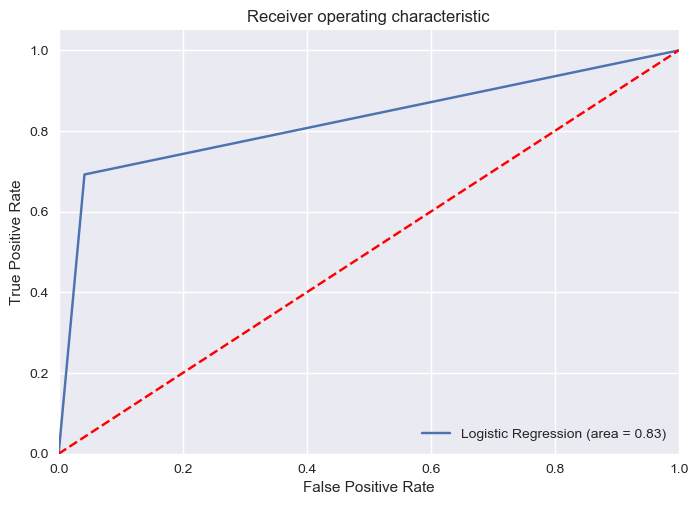

In [271]:
pred_y1 = run_SVC(train_sc_X, train_y, test_sc_X, test_y, 'rbf', 100, 1)
plot_roc(test_y, pred_y1)

This is much better than any results we had so far!

Let's make our parameter grid a little more granular.

In [272]:
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100],
            'gamma':[0.1, 0.5, 1, 5, 10]}
run_cv_w_SVC(train_sc_X, train_y, 'rbf', param_grid)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Tuned SVC parameters: {'C': 10, 'gamma': 5}
Best score is 0.8764012041598248


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished


Area under ROC curve: 0.9022
Recall: 0.8462


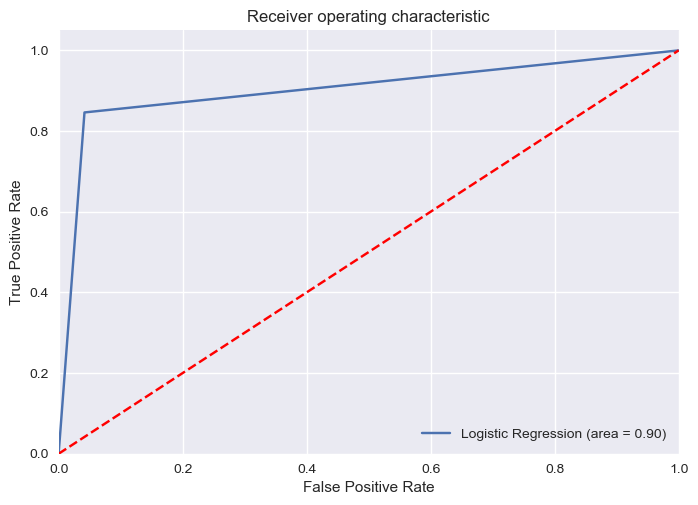

In [273]:
pred_y2 = run_SVC(train_sc_X, train_y, test_sc_X, test_y, 'rbf', 10, 5)
plot_roc(test_y, pred_y2)

The results are improving!

Let's go even more granular on that parameter grid.

In [276]:
param_grid = {'C': [0.1, 1, 5, 7, 9, 10, 20, 50],
            'gamma':[0.5, 1, 2, 3, 4, 5, 10]}
run_cv_w_SVC(train_sc_X, train_y,'rbf', param_grid)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Tuned SVC parameters: {'C': 9, 'gamma': 3}
Best score is 0.891792556102901


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    1.7s finished


Area under ROC curve: 0.9022
Recall: 0.8462


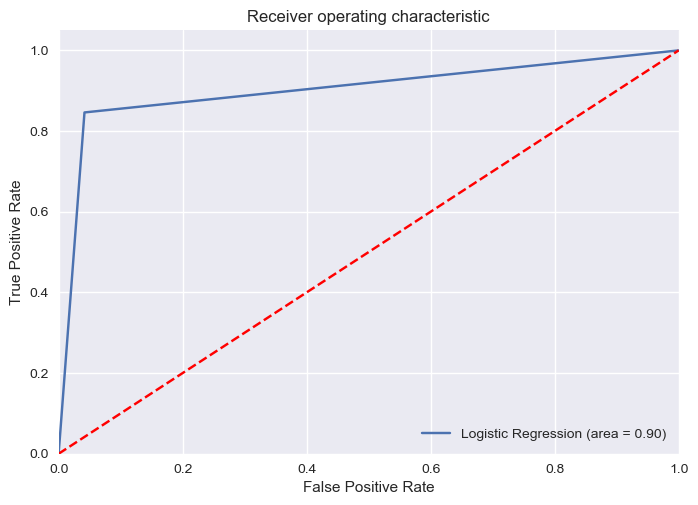

In [277]:
pred_y3 = run_SVC(train_sc_X, train_y, test_sc_X, test_y, 'rbf', 9, 3)
plot_roc(test_y, pred_y3)

Let's check out the accuracy of our last run.

In [278]:
accuracy_score(test_y, pred_y3)

0.918918918918919

The metrics we are getting on our last model are much better than random chance.

We've reached a stopping point for this project. 

***
# Summary of results

Trying to use older data for training a model that would predict newer data, did not work.<br>
This makes sense, as we only used diplomatic exchange data as predictors. International relations are a lot more complex than just diplomatic relations. 

However, treating each year as independent from all other years, produced much better results: <br>
recall of 85%, and accuracy of 92%.

<b>Recommendations:</b><br>
Our best model's prediction is better than random chance and can be used in tandem with other international affairs analysis to predict major wars. Below is a pipeline that will produce predictions on new data (new_X), by simply calling:

```
svc_pipeline.predict(new_X)
```

In [291]:
from sklearn.pipeline import make_pipeline

sc_final = StandardScaler()
clf_final = svm.SVC(kernel = 'rbf', class_weight='balanced', random_state=10, C = 9, gamma = 3)

svc_pipeline = make_pipeline(sc_final, clf_final)
svc_pipeline.fit(X, y)
pred_y = svc_pipeline.predict(X)

roc = roc_auc_score(y.as_matrix(), pred_y)
recall = recall_score(y.as_matrix(), pred_y)
accuracy = accuracy_score(y.as_matrix(), pred_y)

print("Area under ROC curve for training data: %.4f" % (roc))
print("Recall for training data: %.4f" % (recall))
print("Accuracy for training data: %.4f" % (accuracy))

Area under ROC curve for training data: 0.9840
Recall for training data: 1.0000
Accuracy for training data: 0.9780
